## Benchmarking 1

An important hyperparameter when designing a parallel algorithm in Dask is the **number of partitions**, i.e., how the dataset is divided and distributed across memory. In this notebook, we aim to study how our three algorithms scale as we vary the number of partitions used to split the dataset.

In [1]:
from functions import cholesky_tsqr, direct_tsqr, indirect_tsqr

Let's spawn a cluster with 12 workers, organized as follows:

- 1 node (.154): running both the scheduler and the client

- 3 nodes (.216, .116, .113): each running 4 workers (one per core)

In [ ]:
from dask.distributed import Client, SSHCluster

cluster = SSHCluster(
    ["10.67.22.154", "10.67.22.216", "10.67.22.116", "10.67.22.113"],
    connect_options={"known_hosts": None},
    remote_python="/home/ubuntu/miniconda3/bin/python",
    scheduler_options={"port": 8786, "dashboard_address": ":8797"},
    worker_options={
        "nprocs": 4,        # We spawn 4 processes for each VM (4-core) -> 12 workers
        "nthreads": 1       # We use 1 threads. Following Dask documentation, however, Numpy should release well the GIL lock thus we could use more than 1 thread. 
    }
)

client = Client(cluster)

In [3]:
# Let's see if everything went smoothly
cluster

SSHCluster(SSHCluster, 'tcp://10.67.22.154:8786', workers=12, threads=12, memory=23.25 GiB)

To test our three algorithms (Cholesky, Indirect, Direct), we’ll work with the [HIGGS dataset](https://archive.ics.uci.edu/dataset/280/higgs). This dataset is a great choice because it is large enough to challenge the memory of a standard laptop (making Dask an ideal tool) while still being easy to access from the web. Let’s start by loading it into a`dask.array`.

In [4]:
import dask.dataframe as dd
import os

os.chdir("/home/ubuntu") 
path_HIGGS = os.getcwd() + "/datasets/HIGGS.csv"

df = dd.read_csv(path_HIGGS, header=None, blocksize="200MB")    # The block size can be customized, let's start with 200 MB
X_df = df.iloc[:, 1:] 
X_da = X_df.to_dask_array(lengths=True)   # We want it as a matrix (an array, that is)

At this stage, Dask has analyzed the dataset and set up the partitioning, but the chunks haven’t yet been sent to the workers. Let's gather more information on how Dask has planned to partition the dataset (as an array)

In [5]:
#print some info
X_da

dask.array<read-_to_string_dtype-values, shape=(11000000, 28), dtype=float64, chunksize=(275002, 28), chunktype=numpy.ndarray>

Using blocks of $200 , \text{MB}$, Dask divided the array into $40$ chunks. 
Our first goal now is to study how the performance of each algorithm changes (measured as time taken to run the computations) as the number of partitions varies. In this first experiment, we will keep both the number of workers ($12$) and the dataset fixed.

In [6]:
import time
from dask.distributed import wait
import numpy as np

# a function to measure execution time given a generic algorithm
# the function algorithm must return an object whose interface allows to call .persist() on it
def benchmark(X_da, algorithm, rep = 20, verbose = False):
    res = [] 
    if (verbose): print("Fun:", algorithm.__name__,", completion status: ", end = "")
    # repeat _rep_ timesin
    for _ in range(rep):
        if(verbose): print( _, end = " ")
            
        #start a timer
        start = time.time()
        # launch the function (create the DAG)
        Q, R = algorithm(X_da)
        Q = Q.persist()     # Trigger the computations (but don't send anything to the client)
        R = R.persist()
        wait([Q, R])        # Wait until Q and R are available in the worker's memory ...
        end = time.time()   # .. only then stop the timer
        
        res.append(end-start)
        # Remove Q and R from the worker's memory, so that each run is the same
        client.cancel(Q)
        client.cancel(R)
    if(verbose): print()
    return res

Let's start analyzing our algorithms. We will proceed as follows:

- Fix a number of partitions and persist the dataset.
- Repeat each algorithm `rep` times on the repartitioned dataset and measure the execution time.

This loop is necessary to average out possible variations due to the workload on CloudVeneto or other runtime factors. Measuring an algorithm's performance is notoriously challenging, since much depends on the conditions under which the machine is operating, and reproducible results are difficult to obtain. Therefore, we tried to collect our data within a single session to minimize issues related to these factors (for example, performance can be slightly reduced if many other users are simultaneously using the CloudVeneto VMs).

Before each run, we repartition `X_da` and persist it, ensuring that the data is already available in the workers’ memory with the correct partitioning.

As a performance metric, we can use the average time, with the standard deviation as an error measure. However, these metrics are not robust to outliers, which may occur due to the oscillatory nature of machine performance. Therefore, we also collect the median and the MAD (median absolute deviation), which should provide a more robust estimate in the presence of outliers.

In [ ]:
# DO NOT EXECUTE, DATA HAS ALREADY BEEN TAKEN
# helper function that write to file the measured time in the format:
# n_part avg stddev median mad
def write_stats(filename, part, times):
    avg = np.mean(times)
    std = np.std(times)
    med = np.median(times)
    mad = np.median(np.abs(times - med))
    with open(filename, "a") as f:
        f.write(f"{part} {avg} {std} {med} {mad}\n")

n_partitions = list(range(10, 105, 5))
true_npartitions = []

rep = 25

for i, part in enumerate(n_partitions):
    n = X_da.shape[0]
    # Repartition X_da in part partitions
    sizes = [n // part] * part
    sizes[-1] += n % part 
    X_da = X_da.rechunk({0: sizes, 1: -1}).persist()  # Repartition X_da and persist (save in the worker's memory)
    wait(X_da)   # Wait until Dask has finished to repartition (we don't want to count the time used to repartition)
    
    print("N. partitions = ", X_da.npartitions)
    true_npartitions.append(X_da.npartitions)
    
    t_cholesky = benchmark(X_da, cholesky_tsqr, rep = rep, verbose = True)
    t_direct = benchmark(X_da, direct_tsqr, rep = rep, verbose = True)
    t_indirect = benchmark(X_da, indirect_tsqr, rep = rep, verbose = True)

    write_stats("./MAPD_project/data/Cholesky_TimeVsPartitions.txt", part, t_cholesky)
    write_stats("./MAPD_project/data/Direct_TimeVsPartitions.txt", part, t_direct)
    write_stats("./MAPD_project/data/Indirect_TimeVsPartitions.txt", part, t_indirect)   

Let's analyze the results:

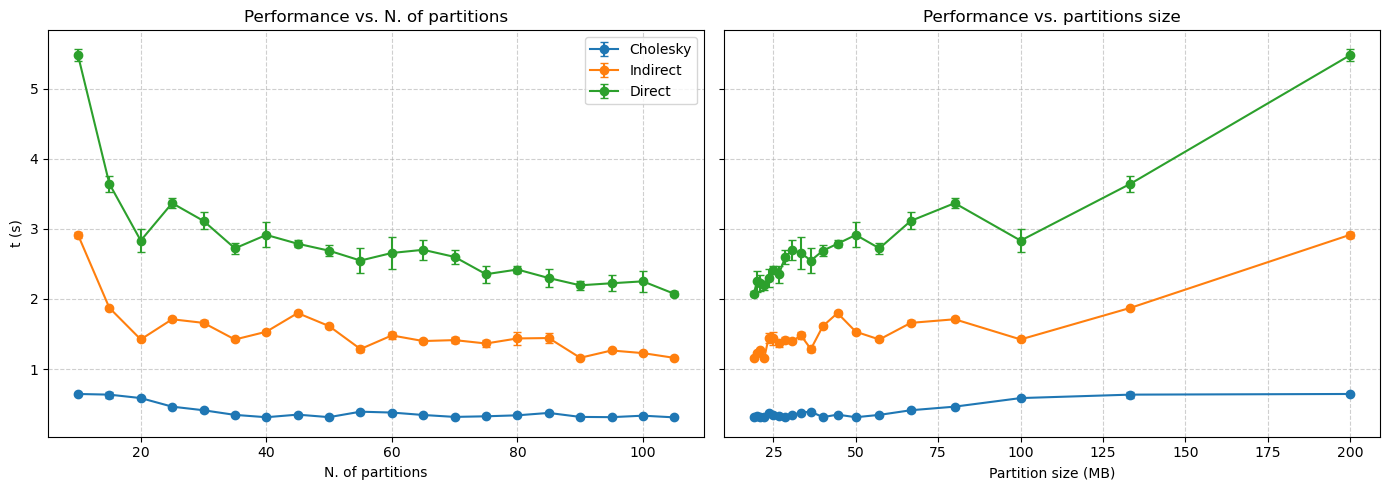

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def load_data(filename):
    data = np.loadtxt(filename, skiprows=1)  
    x = data[:, 0]
    y = data[:, 3]
    err = data[:, 4]
    return x, y, err

files = ["./MAPD_project/data/Cholesky_TimeVsPartitions.txt", "./MAPD_project/data/Indirect_TimeVsPartitions.txt", "./MAPD_project/data/Direct_TimeVsPartitions.txt"]
labels = ["Cholesky", "Indirect", "Direct"]

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

for fname, label in zip(files, labels):
    x, y, err = load_data(fname)
    axes[0].errorbar(x[:20], y[:20], yerr=err[:20],label=label, marker='o', linestyle='-', capsize=3)

axes[0].set_xlabel("N. of partitions")
axes[0].set_ylabel("t (s)")
axes[0].set_title("Performance vs. N. of partitions")
axes[0].grid(True, linestyle="--", alpha=0.6)
axes[0].legend()

size = 2000 # 2 GB approx
for fname, label in zip(files, labels):
    x, y, err = load_data(fname)
    x_trans = size / x[:20]
    axes[1].errorbar(x_trans, y[:20], yerr=err[:20], label=label, marker='o', linestyle='-', capsize=3)

axes[1].set_xlabel("Partition size (MB)")
axes[1].set_title("Performance vs. partitions size")
axes[1].grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()

When the number of partitions is low (especially when it is lower than the total number of workers, 12), performance (measured as the time required to compute both Q and R) worsens dramatically and the measured time increases (left panel). This is an expected phenomenon, since some workers remain idle due to the lack of available partitions.  

Increasing the number of partitions allows workers to operate on smaller chunks (e.g., running QR decompositions or performing matrix multiplications on smaller matrices). As a result, a moderate increase in performance can be observed. When $n_{\text{partitions}} > 30$, performance tends to stabilize, reaching an approximate minimum plateau around 50–60 partitions. Local fluctuations (e.g., when $n_{\text{partitions}} = 25$) are noticeable across some algorithms, but these might simply be due to system load variations or other runtime factors.  

In principle, excessively increasing the number of partitions should introduce overhead from Dask’s orchestration, eventually degrading performance. However, the graph does not show a clear decline up untile $100$ partitions. This can be explained by considering the rightmost part of the plot: the difference between $n_{\text{partitions}} = 99$ and $100$ is vanishingly small, since the partition size decreases inversely with the number of partitions. This explains the seemingly stabilized behavior.  

To clearly observe the performance degradation due to an excessive number of partitions, one would need to increase the number of partitions significantly further:

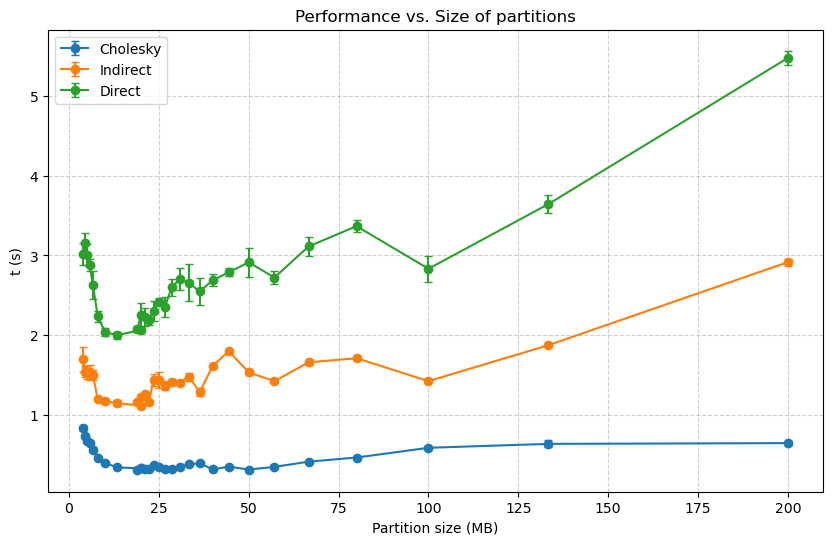

In [9]:
files = ["./MAPD_project/data/Cholesky_TimeVsPartitions.txt", "./MAPD_project/data/Indirect_TimeVsPartitions.txt", "./MAPD_project/data/Direct_TimeVsPartitions.txt"]
labels = ["Cholesky", "Indirect", "Direct"]

plt.figure(figsize=(10, 6))
for fname, label in zip(files, labels):
    x, y, err = load_data(fname)
    plt.errorbar(size / x, y, yerr=err,label=label, marker='o', linestyle='-', capsize=3)

plt.xlabel("Partition size (MB)")
plt.ylabel("t (s)")
plt.title("Performance vs. Size of partitions")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

We pushed the number of partitions up to $n_{\text{partitions}} = 500$. At this point, the chunks on which the workers operate are very small. However, the time required to switch between chunks, combined with orchestration overhead, results in an overall increase in execution time, which is consistent with theoretical expectations.  


An other observation is that the Cholesky-based decomposition achieves significantly better performance compared to the state-of-the-art direct (and indirect) algorithms. At a first glance, this might suggest that Cholesky is the best method for performing QR decomposition on large datasets. However, as already mentioned, the Cholesky approach suffers from severe numerical instability issues when the dataset size grows.

To check whether the outputs of the functions are reasonable, let's compute some stability metrics. We can compare two matrices by computing:

$$
\text{diff}(A, B) = \max |A - B|
$$

Alternatively, we can test whether a matrix $Q$ is truly orthogonal by computing:

$$
\| Q^T Q - I \|_2
$$
or, as an ulterior accuracy metric, we can verify what's the value of:
$$
acc = ||A-QR||_2 / ||R||_2
$$
Let's first compare Cholesky and Direct:

In [10]:
from dask.array.linalg import tsqr
import dask.array as da

Qch, Rch = cholesky_tsqr(X_da)    # Output from Cholesky
Qd, Rd = direct_tsqr(X_da)        # Output from our implementation of Direct method
Qt, Rt = tsqr(X_da)               # Output of official TSQR function in the Dask library

# Now let's trigger the computations
Qch, Rch = Qch.persist(),  Rch.persist()
Qd, Rd = Qd.persist(), Rd.persist()
Qt, Rt = Qt.persist(), Rt.persist()

print("Maximum difference between R_ch and R_dir: ", np.max( np.abs(Rch.T.compute()-Rd.compute()) ))
print("Maximum difference between R_dir and R as computed by the official Dask function: ", np.max(np.abs(Rt.compute()-Rd.compute()) ))

print("***")

print("Maximum difference between Q_ch and Q_dir: ", np.max(np.abs(Qch - Qd)).compute())
print("Maximum difference between Q_dir and Q as computed by the official Dask function: ", np.max(np.abs(Qt - Qd)).compute())

print("***")

print("Ortoghonality test, Cholesky: ||QT Q - I|| = ", np.linalg.norm(np.dot(Qch.T, Qch) - np.eye(Qch.shape[1])).compute())
print("Ortoghonality test, Direct: ||QT Q - I|| = ", np.linalg.norm(np.dot(Qd.T, Qd) - np.eye(Qd.shape[1])).compute())

print("***")

print("Accuracy test, Cholesky: ||A - QR|| / ||R|| = ",(da.linalg.norm(X_da - Qch @ da.from_delayed(Rch.T, shape=(Qch.shape[1], Qch.shape[1]), dtype=Qch.dtype)) / da.linalg.norm(da.from_delayed(Rch.T, shape=(Qch.shape[1], Qch.shape[1]), dtype=Qch.dtype))).compute())
print("Accuracy test, Direct:   ||A - QR|| / ||R|| = ",(da.linalg.norm(X_da - Qd @ Rd) / da.linalg.norm(Rd)).compute())


Maximum difference between R_ch and R_dir:  8378.128683721923
Maximum difference between R_dir and R as computed by the official Dask function:  0.0
***
Maximum difference between Q_ch and Q_dir:  0.024090224207445454
Maximum difference between Q_dir and Q as computed by the official Dask function:  1.734723475976807e-18
***
Ortoghonality test, Cholesky: ||QT Q - I|| =  136.80253145603209
Ortoghonality test, Direct: ||QT Q - I|| =  3.738733016554693e-15
***
Accuracy test, Cholesky: ||A - QR|| / ||R|| =  5.00069299308699
Accuracy test, Direct:   ||A - QR|| / ||R|| =  1.0606990680422727e-15


As expected, the results obtained with the Cholesky method are completely unreliable, whereas the Direct method, although it takes more time, achieves the desired precision.

What about the Indirect method?  The indirect approach is designed as a trade-off between Cholesky and Direct. In principle, it should deliver accuracy close to the Direct QR decomposition regarding $R$ requiring fewer resources and less time, but can be inaccurate on the computation of $Q$.

Let's verify both its numerical stability in practice, to see whether it consistently provides a better balance compared to the other two methods.

In [11]:
Qi, Ri = indirect_tsqr(X_da)      # Output from indirect method
Qd, Rd = direct_tsqr(X_da)        # Output from our implementation of Direct method

# Now let's trigger the computations
Qi, Ri = Qi.persist(),  Ri.persist()
Qd, Rd = Qd.persist(), Rd.persist()

print("Maximum difference between R_dir and R_indir: ", np.max( np.abs(Ri.compute() - Rd.compute()) ))
print("Maximum difference between Q_dir and Q_indir: ", np.max(np.abs(Qi - Qd)).compute())

print("***")

print("Ortoghonality test, Indirect: ||QT Q - I|| = ", np.linalg.norm(np.dot(Qi.T, Qi) - np.eye(Qi.shape[1])).compute())
print("Ortoghonality test, Direct: ||QT Q - I|| = ", np.linalg.norm(np.dot(Qd.T, Qd) - np.eye(Qd.shape[1])).compute())

print("***")

print("Accuracy test, Indirect: ||A - QR|| / ||R|| = ",(da.linalg.norm(X_da - Qi @ Ri).compute()))
print("Accuracy test, Direct:   ||A - QR|| / ||R|| = ",(da.linalg.norm(X_da - Qd @ Rd) / da.linalg.norm(Rd)).compute())

print("Machine accuracy: ", (np.finfo(float).eps))
u, s, v = da.linalg.svd(X_da)
print("Conditioning number of the matrix:", (s.max() / s.min()).compute() )

Maximum difference between R_dir and R_indir:  0.0
Maximum difference between Q_dir and Q_indir:  2.8405554818033973e-15
***
Ortoghonality test, Indirect: ||QT Q - I|| =  8.092177491417409e-15
Ortoghonality test, Direct: ||QT Q - I|| =  3.794366760048199e-15
***
Accuracy test, Indirect: ||A - QR|| / ||R|| =  3.7122184714797015e-12
Accuracy test, Direct:   ||A - QR|| / ||R|| =  1.060931279369101e-15
Machine accuracy:  2.220446049250313e-16
Conditioning number of the matrix: 43.48523648716103


It appears that both the indirect and the direct methods achieve optimal results, although the indirect method takes roughly half the time compared to the direct one. However, the accuracy metric of the indirect method, while close to $0$, is still several orders of magnitude larger than machine precision, giving only a slight indication of the superiority of the direct method.

This peculiar situation, in which both the direct and indirect algorithms yield essentially the same result, is likely just a fortunate case (after all, the condition number of $A$ is not excessively large). For a more ill-conditioned or larger matrix, differences in stability and accuracy would probably become much more evident.

In [12]:
client.close()
cluster.close()